# Training on all articles

In this part I trained a logistic regression model to predict the probability of an article belongs to the each one of eight main major fields from the platform Currículo Lattes.

To strucutre the data, I used the `CountVectorizer` the represent the articles title and `LabelEncoder` to represent the target variable, which is the major field.

At the end we got an **accuracy of 76%** on guessing the correct major field of the test data.

- [Encoding target](#Encoding-target)
- [Train and test split](#Train-and-test-split)
- [Encoding articles titles](#Encoding-articles-titles)
- [Training](#Training)
- [Evaluating](#Evaluating)
- [Evaluating the second option](#Evaluating-the-second-option)

In [91]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

In [92]:
# Reading the already cleaned data from researchers and its articles
with open('data/articles_and_fields_cleaned_df.pickle', 'rb') as f:
    articles_and_fields_df = pickle.load(f)

print('Shape:', articles_and_fields_df.shape)
articles_and_fields_df.head()

Shape: (14537, 4)


,researcher_name,researcher_lattes_id,researcher_major_field,article_title
0,Juarez Morbini Lopes,2612407908632983,Ciências Agrárias,Níveis das vitaminas A e E em dietas de frango...
1,Juarez Morbini Lopes,2612407908632983,Ciências Agrárias,Adição de bentonita sódica como adsorvente de ...
2,Juarez Morbini Lopes,2612407908632983,Ciências Agrárias,Níveis de substituição da DL-metionina pela me...
3,Juarez Morbini Lopes,2612407908632983,Ciências Agrárias,Enzimas de função hepática na aflatoxicose agu...
4,Juarez Morbini Lopes,2612407908632983,Ciências Agrárias,"Efeitos de Níveis das VitaminasA, E, Piridoxin..."


## Encoding target

In [93]:
# Creating an label encoder to transform the target variable to a format acceptable by the logistic regression model
le = LabelEncoder()
articles_and_fields_df['labeled_major_field'] = le.fit_transform(articles_and_fields_df['researcher_major_field'])

In [112]:
# The classes represented
le.classes_

array(['Ciências Agrárias', 'Ciências Biológicas',
       'Ciências Exatas e da Terra', 'Ciências Humanas',
       'Ciências Sociais Aplicadas', 'Ciências da Saúde', 'Engenharias',
       'Lingüística, Letras e Artes'], dtype=object)

## Train and test split

In [95]:
# Splitting the data in train and test
test_size = 0.05

X = articles_and_fields_df.copy()
y = articles_and_fields_df['labeled_major_field'].copy()

X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

print('Train articles:', X_train_.shape[0])
print('Test articles:', X_test_.shape[0])

Train articles: 13810
Test articles: 727


## Encoding articles titles

In [115]:
# Using the count vectorizer, with binary format, to represent the articles titles
vec = CountVectorizer(binary=True, strip_accents='unicode', stop_words=['english', 'portuguese'],
                      min_df=2, max_df=0.13, dtype=np.int8)

In [116]:
# Encoding the train data and getting the generated features
X_train = vec.fit_transform(X_train_['article_title']).toarray()
features = vec.get_feature_names_out()
print('Shape:', X_train.shape)

Shape: (13810, 11776)


In [98]:
# Encoding the test data
X_test = vec.transform(X_test_['article_title'])
print('Shape:', X_test.shape)

Shape: (727, 11776)


## Training

In [99]:
%%time

# Training the logistic regression model
model = LogisticRegression(random_state=0, max_iter=200)
model.fit(X_train, y_train)

CPU times: total: 20min 21s
Wall time: 3min 2s


LogisticRegression(max_iter=200, random_state=0)

## Evaluating

In [100]:
# Evaluating the accuracy of the model on the train and test data
print('Train score:', model.score(X_train, y_train))
print('Test score:', model.score(X_test, y_test))

Train score: 0.9561911658218682
Test score: 0.7606602475928473


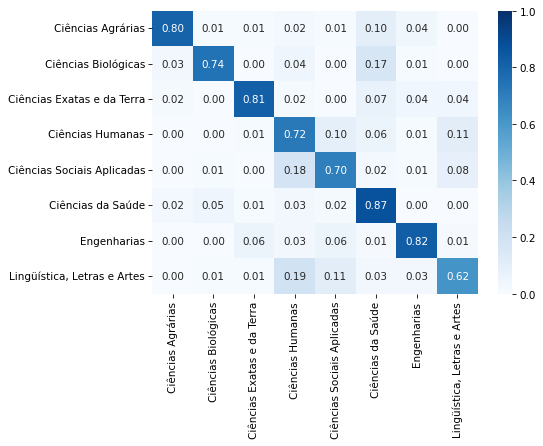

In [101]:
# Confusion matrix to evaluate the model on the specific fields
cm = confusion_matrix(y_test, model.predict(X_test))
cm_df = pd.DataFrame(cm, columns=le.classes_, index=le.classes_)
cm_df_normalized = cm_df.div(cm_df.sum(axis=1), axis=0)

plt.figure(figsize=(7, 5), dpi=75)
sns.heatmap(cm_df_normalized, cmap='Blues', vmax=1.0, annot=True, fmt='.02f');

## Evaluating the second option

I am interest in knowing the accuracy of the model if we consider also the second most likely field predicted for the articles.

In [88]:
# Functions to get the first and second most likely field
first = lambda array: array.argmax()
second = lambda array: array[0].argsort()[::-1][1]

In [102]:
# Filling the train data with the predicted fields
X_train_.reset_index(drop=True, inplace=True)
X_train_['first_field_predicted'] = None
X_train_['second_field_predicted'] = None
for i, row in X_train_.iterrows():
    predicted_proba = model.predict_proba([X_train[i, :]])
    X_train_.at[i, 'first_field_predicted'] = first(predicted_proba)
    X_train_.at[i, 'second_field_predicted'] = second(predicted_proba)

X_train_.head()

,researcher_name,researcher_lattes_id,researcher_major_field,article_title,labeled_major_field,first_field_predicted,second_field_predicted
0,Carlos Eduardo Nazareth Nigro,6508076257538558,Ciências da Saúde,Microbiologia dos Seios Maxilar e Etmoidal em ...,5,5,0
1,Norberto Majlis,8624462757504758,Ciências Exatas e da Terra,Spin-Wave Resonance In Semi-Inanite Anisotropi...,2,2,6
2,Marli de Jesus Ferreira Calux,3674055133660256,Ciências da Saúde,Reactivity of anti-Blomia tropicalis IgG and I...,5,5,1
3,Maria do Carmo Maciel SIlva de Souza,4890971894714867,Ciências Biológicas,Chemical and microbiological characterization ...,1,1,5
4,Sônia Regina Verde da Silva Franco,7072164109862177,Ciências Agrárias,Carcinoma Inflamatório da mama de cadela.,0,0,5


In [103]:
# Accuracy of first or second field predicted on train data
first_field_right = X_train_['labeled_major_field'] == X_train_['first_field_predicted']
second_field_right = X_train_['labeled_major_field'] == X_train_['second_field_predicted']
print('Accuracy of first or second field predicted on train data:',
      (first_field_right | second_field_right).sum() / X_train_.shape[0])

Accuracy of first or second field predicted on train data: 0.9879073135409124


In [110]:
# Filling the test data with the predicted fields
X_test_.reset_index(drop=True, inplace=True)
X_test_['first_field_predicted'] = None
X_test_['second_field_predicted'] = None
for i, row in X_test_.iterrows():
    predicted_proba = model.predict_proba(X_test[i, :])
    X_test_.at[i, 'first_field_predicted'] = first(predicted_proba)
    X_test_.at[i, 'second_field_predicted'] = second(predicted_proba)

# Accuracy of first or second field predicted on test data
first_field_right = X_test_['labeled_major_field'] == X_test_['first_field_predicted']
second_field_right = X_test_['labeled_major_field'] == X_test_['second_field_predicted']
print('Accuracy of first or second field predicted on test data:',
      (first_field_right | second_field_right).sum() / X_test_.shape[0])

Accuracy of first or second field predicted on test data: 0.8913342503438789
